## Introduction

This notebook aims to create a recommendation system algorithm from our trained neural network, then to evaluate it against well-known metrics and a baseline.

## Imports

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.metrics import ndcg_score
from tqdm import tqdm
import matplotlib.pyplot as plt

2025-05-17 09:33:33.489360: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-17 09:33:33.498410: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747467213.507552 1517879 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747467213.510329 1517879 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747467213.519031 1517879 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Loading the test data and the trained model

In [2]:
export_dir = "./exports/test_data/"
test_dataset = pd.read_parquet(export_dir + "test_dataset.pq")
export_dir = "./exports/trained_model/"
model = tf.keras.models.load_model(export_dir + "model.keras")

I0000 00:00:1747467215.324823 1517879 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13674 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


## Recommandation algorithm

The algorithm we chose is pretty simple. For a given user, we predict all the watch ratios we think he would have if he interacted with all the videos of the test data (small matrix).

Then, we sort them and we recommend the videos for which we think he will have the highest watch ratio, which should mean it is the video he would prefer.

To achieve that, given a user_id, we extract all the couples (user features, video features) corresponding to our user_id from the test data, and we predict watch ratios for each of them.

In [3]:
def to_dataset(df: pd.DataFrame) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    user_columns = [f"avg_feat_{i}" for i in range(31)] + [f"avg_category_{i}" for i in range(1, 40)]
    video_columns = ["video_duration", "trend_score"] + [f"feat_{i}" for i in range(31)] + [f"category_{i}" for i in range(1, 40)]
    target = "watch_ratio"
    X_user, X_video, y = df[user_columns].values, df[video_columns], df[target].values
    return X_user, X_video, y, df["video_id"].values

def get_recommendations_and_ground_truth(user_id: int) -> list[int]:
    X_user, X_video, y_test, video_ids = to_dataset(test_dataset[test_dataset["user_id"] == user_id])
    #y_preds = model.predict({"user_input": X_user, "video_input": X_video}, verbose=False).flatten()
    y_preds = model.predict((X_user, X_video), verbose=False).flatten()
    # We sort then flip to get highest watch ratios first
    indexes = np.flip(np.argsort(y_test))
    ground_truth = video_ids[indexes]
    indexes = np.flip(np.argsort(y_preds))
    recommendations = video_ids[indexes]

    return recommendations, ground_truth

## Simulate recommendations for a user

We will simulate the recommandations for a random user in order to test our algorithm:

In [4]:
user_id = 1534
recommendations, ground_truth = get_recommendations_and_ground_truth(user_id)
recommendations

array([9178, 2130,  314, ...,  408, 4010, 4636], shape=(2861,))

So we can recommend videos for a given user, now let's evaluate that.

## Evaluation

We will use the NDCG@K (Normalized Discounted Cumulative Gain) metric to evaluate our model because this metric.

This metric is relevant for our case because it rewards placing relevant videos early in the recommendations.

In [5]:
def evaluate_ndcg_at_10_over_all_users():
    user_columns = [f"avg_feat_{i}" for i in range(31)] + [f"avg_category_{i}" for i in range(1, 40)]
    video_columns = ["video_duration", "trend_score"] + [f"feat_{i}" for i in range(31)] + [f"category_{i}" for i in range(1, 40)]

    ndcg_10_list = []

    for user_id, group in tqdm(test_dataset.groupby("user_id", sort=False)):
        X_user = group[user_columns].to_numpy()
        X_video = group[video_columns].to_numpy()
        y_test = group["watch_ratio"].to_numpy()

        y_pred = model.predict((X_user, X_video), batch_size=512, verbose=False).flatten()
        ndcg = ndcg_score([y_test], [y_pred], k=10)
        ndcg_10_list.append(ndcg)
    
    return ndcg_10_list

ndcg_10_list = evaluate_ndcg_at_10_over_all_users()

100%|██████████| 1354/1354 [00:51<00:00, 26.25it/s]


Now that we computed the ndcg@10 score for all of our users, let's look at the stats:

In [6]:
print(f"Mean ndcg@10 over all of the small_matrix users: {np.mean(ndcg_10_list):.4f}")
print(f"Median ndcg@10 over all of the small_matrix users: {np.median(ndcg_10_list):.4f}")
print(f"Max ndcg@10 over all of the small_matrix users: {np.max(ndcg_10_list):.4f}")
print(f"Min ndcg@10 over all of the small_matrix users: {np.min(ndcg_10_list):.4f}")

Mean ndcg@10 over all of the small_matrix users: 0.5372
Median ndcg@10 over all of the small_matrix users: 0.5413
Max ndcg@10 over all of the small_matrix users: 0.9457
Min ndcg@10 over all of the small_matrix users: 0.1023


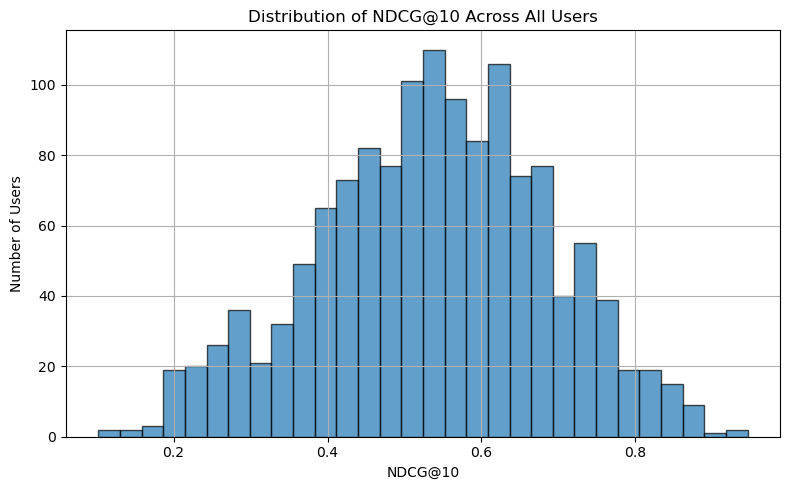

In [7]:
plt.figure(figsize=(8, 5))
plt.hist(ndcg_10_list, bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of NDCG@10 Across All Users')
plt.xlabel('NDCG@10')
plt.ylabel('Number of Users')
plt.grid(True)
plt.tight_layout()
plt.show()

We can see that our NDCG scores are centered around 0.6, with a mean value almost equal to the median value.

Our NDCG scores varry from 0.11 to 0.95, which shows that our recommendation system manages to be almost perfect for some users but completely fails with others. Maybe this is due to a lack of data from these users, or users who do not have patterns in their video watching behavior.

### Comparing to our baseline

Let's take our baseline which predicts for each video its average watch ratio, and compute its NDCG@10 scores accross all the users to compare.

In [8]:
test_dataset["mean_watch_ratio"] = test_dataset.groupby("video_id")["watch_ratio"].mean()

def get_user_recommendation_data_baseline(user: int):
    preds = np.array(test_dataset[test_dataset["user_id"] == user]["mean_watch_ratio"].to_list())
    user_mat = test_dataset[test_dataset["user_id"] == user].reset_index(drop=True)
    to_recommend_index = np.flip(preds.argsort())
    to_recommend = user_mat["video_id"][to_recommend_index].values
    ground_truth_index = np.flip(user_mat["watch_ratio"].values.argsort())
    ground_truth = user_mat["video_id"][ground_truth_index].values
    return to_recommend, ground_truth

ndcg_10_baseline_list = []

for user_id, group in tqdm(test_dataset.groupby("user_id", sort=False)):
    if len(group) < 10:
        continue

    y_pred, y_truth = get_user_recommendation_data_baseline(user_id)
    ndcg = ndcg_score([y_truth], [y_pred], k=10)
    ndcg_10_baseline_list.append(ndcg)

print(f"Mean ndcg@10 over all of the small_matrix users: {np.mean(ndcg_10_baseline_list):.4f}")
print(f"Median ndcg@10 over all of the small_matrix users: {np.median(ndcg_10_baseline_list):.4f}")
print(f"Max ndcg@10 over all of the small_matrix users: {np.max(ndcg_10_baseline_list):.4f}")
print(f"Min ndcg@10 over all of the small_matrix users: {np.min(ndcg_10_baseline_list):.4f}")

100%|██████████| 1354/1354 [00:05<00:00, 240.44it/s]

Mean ndcg@10 over all of the small_matrix users: 0.4733
Median ndcg@10 over all of the small_matrix users: 0.4713
Max ndcg@10 over all of the small_matrix users: 0.7984
Min ndcg@10 over all of the small_matrix users: 0.1444


We can clearly see that this baseline has worse results than our recommendation system. It has worse mean, median and max values, with roughly the same min value.

## Conclusion

In this project, we successfully developed a complete and scalable recommendation system tailored to the KuaiRec dataset. Throughout the process, we encountered and addressed several real-world challenges typical of recommender systems, including working with highly sparse data: our training matrix had a density of only 16%, which is common in practical applications.

While our system is not without its limitations and leaves room for future improvement, it achieved promising results, especially when benchmarked against a strong baseline. This indicates that our model effectively captures and responds to users preferences and behaviors when recommending videos.

Beyond the technical achievements, this project has been a valuable learning experience. It deepened my understanding of recommender systems, large-scale data handling, and the importance of critical analysis and iterative testing. I learned the value of continuously evaluating and refining my solutions to ensure their reliability and relevance in real-world scenarios.